In [1]:
import numpy as np
import pandas as pd

import pandas_profiling as pp
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from scipy import misc
import scipy.ndimage as sn


TRAINPATH = '/home/izinizik/kagle_twarz/dane/training.csv'
#TESTPATH = '/home/izinizik/kagle_twarz/test.csv'

In [2]:
#use_cuda = torch.cuda.is_available()
use_cuda = False
device = torch.device("cuda:0" if use_cuda else "cpu")
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [3]:
df_train = pd.read_csv(TRAINPATH)
#df_test = pd.read_csv(TESTPATH)

In [4]:
df_train['Image'] = df_train['Image'].apply(lambda im: np.fromstring(im, sep=' '))

In [5]:
names = ['nose_tip_x','nose_tip_y','Image']

In [6]:
df_train_named = df_train[names].dropna()

In [7]:
df_train_named.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7049 entries, 0 to 7048
Data columns (total 3 columns):
nose_tip_x    7049 non-null float64
nose_tip_y    7049 non-null float64
Image         7049 non-null object
dtypes: float64(2), object(1)
memory usage: 220.3+ KB


In [8]:
n_labels = len(names)-1

In [9]:
X = np.vstack(df_train_named.iloc[:,n_labels].values)/ 255. 
y = df_train_named.iloc[:,:n_labels].values

In [10]:
def plot_sample(images_array, dim=1, key=np.empty([10000,0]), key_pred=np.empty([10000,0])):
    
    fig = plt.figure(figsize=(8, 8))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
    sample = np.random.choice(len(images_array), dim*dim, replace=False)
    for i in range(dim*dim):
        ax = fig.add_subplot(dim, dim, i + 1, xticks=[], yticks=[])
        ax.imshow(images_array[sample[i]].reshape(96,96), cmap='gray')
        ax.scatter(key[sample[i],0::2], key[sample[i],1::2], s=20, marker='.', c='red')
        ax.scatter(key_pred[sample[i],0::2], key_pred[sample[i],1::2], s=20, marker='.', c='blue')

In [11]:
def rotation(image, key, angle):
    image = image.reshape(96,96)
    im_rot = sn.rotate(image, angle, reshape=False, mode='nearest') 
    org_center = (np.array(image.shape[:2][::-1])-1)/2.
    rot_center = (np.array(im_rot.shape[:2][::-1])-1)/2.
    orgx = key[0::2]-org_center[0]
    orgy = key[1::2]-org_center[1]
    a = np.deg2rad(angle)
    key_rot = np.array([orgx*np.cos(a) + orgy*np.sin(a),
        -orgx*np.sin(a) + orgy*np.cos(a) ])
    key_rot[0,:] += rot_center[0]
    key_rot[1,:] += rot_center[1]
    return im_rot.reshape(1,96*96)[0], key_rot.T.reshape(1,key.shape[0])[0]

In [12]:
def shift(image, key, shift):
    image = image.reshape(96,96)
    im_shift = sn.shift(image, shift, mode='nearest')
    key_shift = np.array([key[0::2]+shift[1],key[1::2]+shift[0]])
    return im_shift.reshape(1,96*96)[0], key_shift.T.reshape(1,key.shape[0])[0]

In [13]:
sample_rot = np.random.choice(len(y), np.int(len(y)*0.5), replace=False)
sample_shift = np.random.choice(len(y), np.int(len(y)*0.5), replace=False)
X_affin, y_affin = [], []

for i in range(len(y)):
    if i in sample_rot:
        delta = np.random.randint(6)-10
        rot = rotation(X[i], y[i], delta)
        if i in sample_shift:
            vector = np.random.randint(6,size=2)-10
            shifted = shift(rot[0], rot[1], vector)
            X_affin.append(shifted[0])
            y_affin.append(shifted[1])
        else:
            X_affin.append(rot[0])
            y_affin.append(rot[1])
    elif i in sample_shift:
        vector = np.random.randint(10,size=2)-20
        shifted = shift(X[i], y[i], vector)
        X_affin.append(shifted[0])
        y_affin.append(shifted[1])

In [14]:
X_train, X_valid, y_train, y_valid = train_test_split(np.concatenate((X,X_affin)), np.concatenate((y,y_affin)))

In [15]:
np.shape(y_train)

(9260, 2)

In [16]:
criterion = nn.MSELoss().to(device)

In [17]:
const_prediction_train = np.repeat(y_train.mean(axis=0).reshape(1,-1), y_train.shape[0], axis=0)
criterion(torch.tensor(const_prediction_train), torch.tensor(y_train)).item()

59.798738587354464

In [18]:
const_prediction_valid = np.repeat(y_train.mean(axis=0).reshape(1,-1), y_valid.shape[0], axis=0)
criterion(torch.tensor(const_prediction_valid), torch.tensor(y_valid)).item()

59.139229603637546

In [19]:
class MyDataset(Dataset):

    def __init__(self, X, y):
        self.data = torch.tensor(X).type(dtype).reshape(-1,1,96,96).to(device)
        self.label = torch.tensor(y).type(dtype).to(device)
        self.len = X.shape[0]

    def __getitem__(self, index):
        return self.data[index], self.label[index]

    def __len__(self):
        return self.len

In [20]:
dataset_train = MyDataset(X_train, y_train)
train_loader = DataLoader(dataset=dataset_train,
                          batch_size=32,
                          shuffle=True,
                          num_workers=4)

In [21]:
dataset_valid = MyDataset(X_valid, y_valid)
valid_loader = DataLoader(dataset=dataset_valid,
                          batch_size=32,
                          shuffle=True,
                          num_workers=4)

In [22]:
class ConvNet(nn.Module):

    def __init__(self):

        super(ConvNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        
        self.drop1 = nn.Dropout(p = 0.1)
        self.drop2 = nn.Dropout(p = 0.1)
        self.drop3 = nn.Dropout(p = 0.1)
        self.drop4 = nn.Dropout(p = 0.2)
        self.drop5 = nn.Dropout(p = 0.2)
        
        self.fc1 = nn.Linear(in_features=32*3*3, out_features=2)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
      
    def forward(self, x):
        
        x = self.drop1(self.pool(F.relu(self.conv1(x))))
        x = self.drop2(self.pool(F.relu(self.conv2(x))))
        x = self.drop3(self.pool(F.relu(self.conv3(x))))
        x = self.drop4(self.pool(F.relu(self.conv4(x))))
        x = self.drop5(self.pool(F.relu(self.conv5(x))))
        
        x = x.view(x.size(0), -1)
        
        x = self.fc1(x)

        return(x)

In [23]:
def train_net(net, n_epochs=500, store_every=10, print_every=10):

    hist = {'train': [], 'valid': []}
    
    
    for epoch in range(n_epochs): 
        
        
        net.train()
        
        for i, data in enumerate(train_loader, 0):
            input_train, label_train = data
            output_train = net(input_train) 
            loss = criterion(output_train[label_train==label_train], label_train[label_train==label_train])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        if epoch % store_every == 0: 
            net.eval()
            loss_sum = 0.0
            n_loss = 0
            for i, data in enumerate(train_loader, 0):
                input_train, label_train = data
                output_train = net(input_train) 
                loss_sum += criterion(output_train[label_train==label_train],label_train[label_train==label_train]).item()
                n_loss += 1
            hist['train'].append(loss_sum/n_loss)
            loss_sum_valid = 0.0
            n_loss_valid = 0
            for i, data in enumerate(valid_loader, 0):
                input_valid, label_valid = data
                output_valid = net(input_valid) 
                loss_sum_valid += criterion(output_valid[label_valid==label_valid],label_valid[label_valid==label_valid]).item()
                n_loss_valid += 1
            hist['valid'].append(loss_sum_valid/n_loss_valid)


        if epoch % print_every == 0:        
            print('Epoch: {}, Loss train: {}, Loss valid: {}'.format(epoch, hist['train'][epoch], hist['valid'][epoch]))
    print('Epoch: {}, Loss train: {}, Loss valid: {}'.format(epoch, hist['train'][epoch], hist['valid'][epoch]))
    return net, hist

In [24]:
convnet = ConvNet().to(device)

In [25]:
def total_number_of_weights(model):
    return sum([val.numel() for key, val in model.state_dict().items()])

total_number_of_weights(convnet)

33122

In [34]:
pre_trained=torch.load('wagi_mouth_center_top_lip.pt')

In [35]:
my_model=convnet.state_dict()

In [36]:
for key,value in my_model.items():
    if  (key != 'fc1.weight') and (key != 'fc1.bias'):
        my_model[key]=pre_trained[key]

In [37]:
convnet.load_state_dict(my_model)

In [38]:
optimizer = optim.Adam(params = convnet.parameters(), lr = 3e-3)

In [39]:
Convnet_trained, hist = train_net(convnet, n_epochs=10, store_every=1, print_every=2)

Epoch: 0, Loss train: 35.459259556079736, Loss valid: 34.07208393529518
Epoch: 2, Loss train: 23.780522478037867, Loss valid: 22.57939003423317
Epoch: 4, Loss train: 21.197180527654186, Loss valid: 19.995422058498736
Epoch: 6, Loss train: 24.555626941549367, Loss valid: 23.740237049220763
Epoch: 8, Loss train: 17.04683301202182, Loss valid: 16.039753648423655
Epoch: 9, Loss train: 19.58968821887312, Loss valid: 18.9314224695422


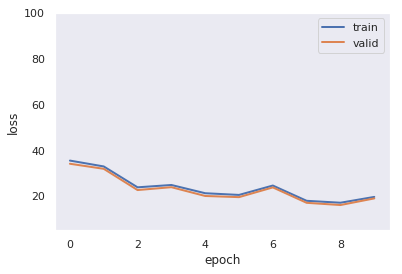

In [40]:
 def train_valid_plot(train, valid):
    plt.plot(train, linewidth=2, label="train")
    plt.plot(valid, linewidth=2, label="valid")
    plt.grid()
    plt.legend()
    plt.ylim(5, 100) 
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.show()
    
train_valid_plot(hist['train'], hist['valid'])

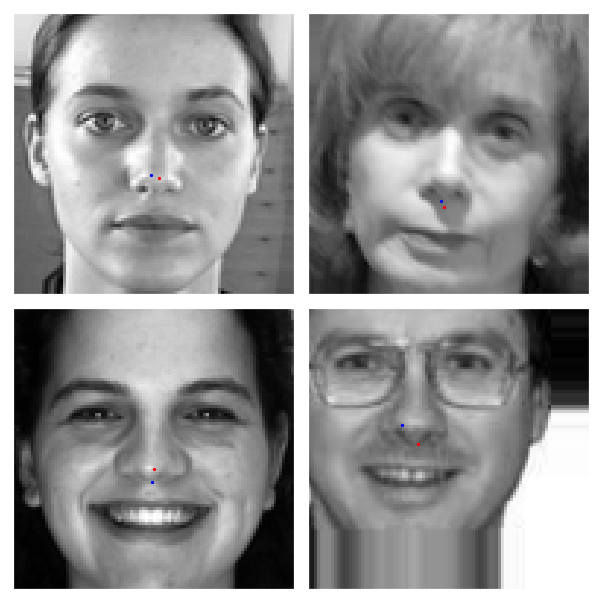

In [41]:
y_pred = Convnet_trained(torch.tensor(X_valid[:100]).float().reshape(-1,1,96,96)).detach().numpy()
plot_sample(X_valid[:100], dim=2, key=y_valid[:100], key_pred=y_pred) #*48+48

In [42]:
torch.save(Convnet_trained.state_dict(), 'pre.h5')

In [43]:
y_pred

array([[46.81115 , 62.468384],
       [46.10267 , 63.386726],
       [43.052086, 60.188766],
       [31.7383  , 42.165634],
       [45.782364, 56.691452],
       [46.999405, 53.07896 ],
       [30.960049, 39.450478],
       [45.352547, 62.417713],
       [46.88289 , 55.033585],
       [47.508965, 60.36204 ],
       [48.210617, 60.114944],
       [46.361385, 58.8162  ],
       [40.627502, 53.66085 ],
       [48.673737, 63.78255 ],
       [47.81461 , 63.494476],
       [49.514076, 66.606445],
       [47.148468, 59.350533],
       [48.400402, 67.02742 ],
       [46.565033, 58.504852],
       [31.498608, 50.388477],
       [31.626898, 39.52191 ],
       [37.802567, 58.926815],
       [38.92887 , 55.716576],
       [47.805153, 60.26893 ],
       [49.487495, 60.002743],
       [37.47497 , 52.10153 ],
       [45.93831 , 62.14399 ],
       [45.235374, 65.60133 ],
       [32.088413, 46.49318 ],
       [32.421013, 50.205387],
       [26.987698, 42.148388],
       [45.655323, 64.55838 ],
       [